In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014

from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import numpy as np
from scipy import optimize as opt
from scipy import ndimage

from astropy import units

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind
import calcGrid

from auriga_basics import *
from auriga_functions import *

%matplotlib inline

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  wa

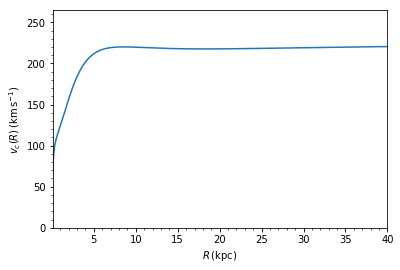

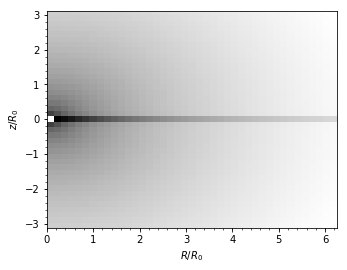

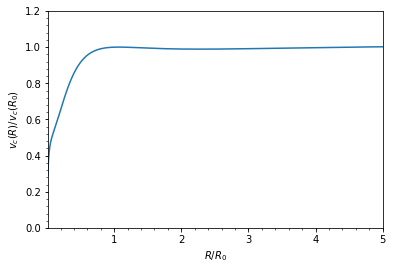

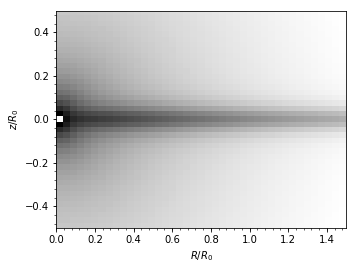

In [3]:
# galpy playtime


r0 = 8.
v0 = 220.

a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.6  
a_nfw = 4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 
mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp, ro = r0, vo = v0)
nfwp = NFWpot(a = a_nfw, normalize = n_nfw, ro = r0, vo = v0)
hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw), ro = r0, vo = v0)
   
mp.turn_physical_on()
nfwp.turn_physical_on()
hep.turn_physical_on()
pot = [mp,nfwp,hep]

plotRotcurve(pot)
plotDensities(pot, rmin = 0. * units.kpc, rmax = 50. * units.kpc, zmin = -25. * units.kpc, \
              zmax = 25. * units.kpc, log = True, nrs = 41, nzs = 41)


mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp)
nfwp = NFWpot(a = a_nfw, normalize = n_nfw)
hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw))
   
pot2 = [mp,nfwp,hep]

plotRotcurve(pot2)
plotDensities(pot2, log = True, nrs = 41, nzs = 41)



In [4]:
R = np.arange(0., 50., 0.5)
#R = R/r0
z = np.arange(-25., 25., 0.5)
#z = z/r0
rho, rho2, r = np.zeros((len(z), len(R))), np.zeros((len(z), len(R))), np.zeros((len(z), len(R)))

for ii, zii in enumerate(z):
    for jj, Rjj in enumerate(R):
        rho[ii, jj] = evaluateDensities(pot, Rjj/r0, zii/r0)
        rho2[ii, jj] = evaluateDensities(pot2, Rjj/r0, zii/r0) * bovy_conversion.dens_in_msolpc3(v0,r0) #* 10.
        r[ii, jj] = np.sqrt(Rjj**2 + zii**2)

r = np.ravel(r)
print('rho 1 (potential initialized with r0/v0)\n')
print(rho)
print('\nrho 2 (potential initialized without r0/v0)\n')
print(rho2)
print('\ndifference between rho2 and rho1\n')
print(rho2-rho)


/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

rho 1 (potential initialized with r0/v0)

[[ 0.00143106  0.00143054  0.00142898 ...,  0.00029725  0.00029197
   0.00028681]
 [ 0.00148457  0.00148401  0.00148233 ...,  0.0003      0.00029463
   0.00028938]
 [ 0.00154092  0.00154032  0.00153852 ...,  0.00030274  0.00029728
   0.00029195]
 ..., 
 [ 0.00160035  0.0015997   0.00159775 ...,  0.00030546  0.00029992
   0.0002945 ]
 [ 0.00154092  0.00154032  0.00153852 ...,  0.00030274  0.00029728
   0.00029195]
 [ 0.00148457  0.00148401  0.00148233 ...,  0.0003      0.00029463
   0.00028938]]

rho 2 (potential initialized without r0/v0)

[[ 0.00143106  0.00143054  0.00142898 ...,  0.00029725  0.00029197
   0.00028681]
 [ 0.00148457  0.00148401  0.0014

Zu galpy Einheiten und so:
--

- evaluateDensities ist wohl immer in galpy units, also teile durch r0.
- wenn Potential schon mit r0 und z0 initialisiert wurde ist es bereits in physikalischen einheiten, auch der evaluateDensities output
- wenn nicht, muss man den Density output umwandeln mit * bovy_conversion.dens_in_msolpc3(v0,r0)



5000.0


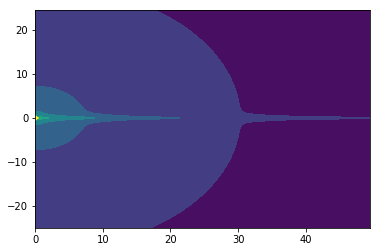

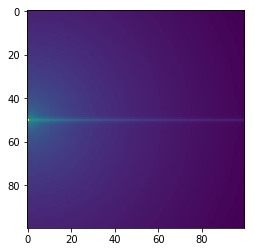

In [5]:
rho[np.isinf(rho)] = np.nanargmax(rho)
print(np.max(rho))
plt.contourf(R, z, rho, norm=LogNorm(vmin=np.min(rho), vmax=np.max(rho)))

plt.show()
plt.imshow(rho, norm=LogNorm(vmin=np.min(rho), vmax=np.max(rho)))


In [6]:
def galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, v0,\
                  R = None, z = None, r0 = None):    
    
    # stell sicher dass n_mp + n_nfw + n_he = 1, zb mit 
    n_he = 1. - (n_mp + n_nfw)
    mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp)
    nfwp = NFWpot(a = a_nfw, normalize = n_nfw)
    hep = HEpot(a = a_he, normalize = n_he)
    
    pot = [mp, nfwp, hep]
    densi = np.zeros([len(z), len(R)])
    for ii, zjj in enumerate(z):
        for jj, Rii in enumerate(R):
            densi[ii, jj] = evaluateDensities(pot, Rii/r0, zjj/r0) #* bovy_conversion.dens_in_msolpc3(v0,r0) * 10.
    
    densi[np.isinf(densi)] = np.nanargmax(densi)
    plt.contourf(R, z, densi, norm=LogNorm(vmin=np.min(densi), vmax=np.max(densi)))

    return densi



In [9]:
def RMS(x, R, z, N, rho, r0):
    a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, v0 = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    ydata = rho
    ymodel = galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, v0, R, z, r0) * bovy_conversion.dens_in_msolpc3(v0,r0)
    RMS = np.sqrt(1./N*np.sum((ydata - ymodel)**2))
    return RMS

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/Potential.py:1617: RuntimeWarning: invalid value encountered in double_scalars
  use_physical=False)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1536: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.war

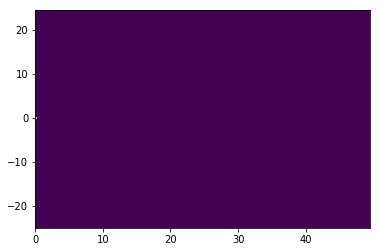

In [10]:
a_mp = 0.4 #0.5 
b_mp = 0.1 #0.0375 
n_mp = 0.8 #0.6  
a_nfw = 3. #4.5 
n_nfw = 0.1 #0.35 
a_he = 6. # 0.6 / 8. 
v0 = 200. #220


v0 = 220.

a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.6  
a_nfw = 4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 

x0 = (a_mp, b_mp, n_mp,  a_nfw , n_nfw , a_he, v0) #n_he

bounds = ((0., None), (0., None), (0., 1.), (0., None), (0., 1.), (0., None), (0., None)) #n_he

r0 = 8.
N = len(R)

res = opt.minimize(RMS, x0 = x0, args= (R, z, N, rho, r0), bounds = bounds)



In [11]:
res

      fun: nan
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.13686838e-05,  -3.97903932e-05,  -1.70530257e-05,
         0.00000000e+00,  -2.27373675e-05,  -1.70530257e-05,
        -8.02157274e-01])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 176
      nit: 1
   status: 2
  success: False
        x: array([  5.00000000e-01,   3.75000000e-02,   6.00000000e-01,
         4.50000000e+00,   3.50000000e-01,   7.50000000e-02,
         2.20799241e+02])